<a href="https://colab.research.google.com/github/nraptis/Machine-Learning-Notebooks/blob/main/Student_MLE_MiniProject_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini Project: Deep Learning with Keras

In this mini-project we'll be building a deep learning classifier using Keras to predict income from the popular [Adult Income dataset](http://www.cs.toronto.edu/~delve/data/adult/adultDetail.html).

Predicting income from demographic and socio-economic information is an important task with real-world applications, such as financial planning, market research, and social policy analysis. The Adult dataset, sometimes referred to as the "Census Income" dataset, contains a vast amount of anonymized data on individuals, including features such as age, education, marital status, occupation, and more. Our objective is to leverage this data to train a deep learning model that can effectively predict whether an individual's income exceeds $50,000 annually or not.

Throughout this Colab, we will walk you through the entire process of building a deep learning classifier using Keras, a high-level neural network API that runs on top of TensorFlow. Keras is known for its user-friendly and intuitive interface, making it an excellent choice for both beginners and experienced deep learning practitioners.

Here's a brief outline of what we will cover in this mini-project:

1. **Data Preprocessing:** We will start by loading and exploring the Adult dataset.

2. **Building the Deep Learning Model:** We will construct a neural network using Keras, where we'll dive into understanding the key components of a neural network, including layers, activation functions, and optimization algorithms.

3. **Model Training:** With our model architecture in place, we will split the data into training and validation sets and train the neural network on the training data. We will monitor the training process to prevent overfitting and enhance generalization.

4. **Model Evaluation:** After training, we'll assess the performance of our model on the test dataset.

By the end of this tutorial, you will not only have a functional deep learning classifier for income prediction but also gain valuable insights into how to leverage the power of neural networks for solving real-world classification tasks.


In [ ]:
!pip install scikeras
# !pip install -U scikit-learn scikeras

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from sklearn.pipeline import Pipeline

You can download the Adult data from the link [here](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data).

Here are your tasks:

  1. Load the Adult data into a Pandas Dataframe.
  2. Ensure the dataset has properly named columns. If the columns are not read in, assign them by referencing the dataset documentation.
  3. Display the first five rows of the dataset.

In [ ]:
DATA_PATH = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
# Download the dataset and load it into a pandas DataFrame
column_names = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship",
    "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "salary"
]
df = pd.read_csv(DATA_PATH, header=None, names=column_names)

for column_name in df.columns:
    if pd.api.types.is_string_dtype(df[column_name]):
        df[column_name] = df[column_name].str.strip()

In [ ]:
# Display the first few rows of the DataFrame
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


If you're not already familiar with the Adult dataset, it's important to do some exploratory data analysis.

Here are your tasks:

  1. Do exploratory data analysis to give you some better intuition for the dataset. This is a bit open-ended. How many rows/columns are there? How are NULL values represented? What's the percentage of positive cases in the dataset?

  2. Drop all rows with NULL values.

  3. Use Scikit-Learn's [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) to convert the `income` column with a data type string to a binary variable.

In [ ]:
# Do some exploratory analysis. How many rows/columns are there? How are NULL
# values represented? What's the percentrage of positive cases in the dataset?
# Shape of dataset
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

# Missing looks like it's represented by "?"
print("\nUnique values in 'workclass' (to confirm missing encoding):")
print(df['workclass'].unique())

# What's the percentage of positive cases in the dataset?
over_50k_rate = (df['salary'] == '>50K').sum() / len(df)
print(f"\nPercentage of positive income cases (>50K): {over_50k_rate * 100.0:.2f}%")

Rows: 32561, Columns: 15

Unique values in 'workclass' (to confirm missing encoding):
['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' '?'
 'Self-emp-inc' 'Without-pay' 'Never-worked']

Percentage of positive income cases (>50K): 24.08%


In [ ]:
# Find all NULL values and drop them
missing_counts = (df == '?').sum()

# Drop just the "workclass" == "?"
df = df[df["workclass"] != "?"]

# Drop all rows where any column has value of "?"
df = df[(df != '?').all(axis=1)]

In [ ]:
# Use Scikit-Learn's LabelEncoder to convert the income column with a data type
# string to a binary variable.
label_encoder = LabelEncoder()
df['salary'] = label_encoder.fit_transform(df['salary'])
print(df['salary'].unique())

[0 1]


1. Split the data into training and test sets. Remember not to include the label you're trying to predict, `income`, as a column in your training data.

In [ ]:
# Split dataset into training and test sets
X = df.drop(["salary"], axis=1)
y = df["salary"]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In machine learning, the Receiver Operating Characteristic (ROC) curve and the Area Under the Curve (AUC) metric are commonly used to evaluate the performance of binary classification models. These are valuable tools for understanding how well a model can distinguish between the positive and negative classes in a classification problem.

Let's break down each concept:

1. ROC Curve:
The ROC curve is a graphical representation of a binary classifier's performance as the discrimination threshold is varied. It is created by plotting the True Positive Rate (TPR) against the False Positive Rate (FPR) at different threshold values. Here's how these rates are calculated:

- True Positive Rate (TPR), also called Sensitivity or Recall, measures the proportion of actual positive instances that are correctly identified by the model:
   TPR = True Positives / (True Positives + False Negatives)

- False Positive Rate (FPR) measures the proportion of actual negative instances that are incorrectly classified as positive by the model:
   FPR = False Positives / (False Positives + True Negatives)

The ROC curve is useful because it shows how well a classifier can trade off between sensitivity and specificity across different threshold values. The ideal ROC curve hugs the top-left corner, indicating a high TPR and low FPR, meaning the classifier is excellent at distinguishing between the two classes.

2. AUC (Area Under the Curve):
The AUC is a scalar metric derived from the ROC curve. It represents the area under the ROC curve, hence its name. The AUC ranges from 0 to 1, where 0 indicates a very poor classifier (always predicting the opposite class) and 1 signifies a perfect classifier (making all correct predictions).

The AUC metric is beneficial because it provides a single value to summarize the classifier's overall performance across all possible threshold values. It is particularly useful when dealing with imbalanced datasets, where one class significantly outnumbers the other. In such cases, accuracy alone might not be a reliable evaluation metric, and AUC can provide a more robust performance measure.

A quick rule of thumb for interpreting AUC values:
- AUC ≈ 0.5: The model performs no better than random guessing.
- 0.5 < AUC < 0.7: The model has poor to fair performance.
- 0.7 < AUC < 0.9: The model has good to excellent performance.
- AUC ≈ 1: The model is close to or has a perfect performance.

Here are your tasks:

  1. Use Scikit-Learn's [roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) to calculate the AUC score for a method that always predicts the majority class.  

In [ ]:
# Use Scikit-Learn's roc_auc_score to calculate the AUC score for a method that
# always predicts the majority class.
print(y_test.value_counts(normalize=True))
majority_class = y_test.value_counts().idxmax()
y_pred_majority = [majority_class] * len(y_test)
auc_score = roc_auc_score(y_test, y_pred_majority)
print(f"AUC for majority-class predictor: {auc_score:.2f}")

salary
0    0.748442
1    0.251558
Name: proportion, dtype: float64
AUC for majority-class predictor: 0.50


Now, let's do a little feature engineering.

1. Use Scikit-Learn's [ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) to apply One Hot Encoding to the categorical variables in `workclass`, `education`, `marital-status`, `occupation`, `relationship`, 'race', `sex`, and `native-country`. Also, apply [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) to the remaining continuous features. How many columns will the dataframe have after these columns transformations are applied?

In [ ]:
# Use Scikit-Learn's ColumnTransformer to apply One Hot Encoding to the
# categorical variables in workclass, education, marital-status, occupation,
# relationship, 'race', sex, and native-country. #Also, apply MinMaxScaler to
# the remaining continuous features.

categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
# categorical_transformer = OneHotEncoder() # here we don't miss any column, but it seems good practice
continuous_transformer = MinMaxScaler()

categorical_features = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]
continuous_features = list((set(X_train.columns) | set(X_test.columns)) - set(categorical_features))
print("categorical_features =", categorical_features)
print("continuous_features =", continuous_features)

column_transformer = ColumnTransformer(
    transformers=[
        ('con', continuous_transformer, continuous_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Fit on train
column_transformer.fit(X_train)

# Now it's fitted, so these exist.
feature_names = column_transformer.get_feature_names_out()

# Scipi sparse matrix, becoz of
X_train_array = column_transformer.transform(X_train)
X_test_array = column_transformer.transform(X_test)

# Build DataFrames with the SAME column order
# This is not "necessary" in this case, but I prefer
# to use sparse ohe if I am to use this in future.

# X_train_transformed = pd.DataFrame(X_train_array, columns=feature_names, index=X_train.index)
# X_test_transformed  = pd.DataFrame(X_test_array,  columns=feature_names, index=X_test.index)

X_train_transformed = pd.DataFrame.sparse.from_spmatrix(X_train_array, columns=feature_names, index=X_train.index)
X_test_transformed  = pd.DataFrame.sparse.from_spmatrix(X_test_array,  columns=feature_names, index=X_test.index)
print(type(X_test_transformed))

categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
continuous_features = ['education-num', 'age', 'capital-gain', 'hours-per-week', 'capital-loss', 'fnlwgt']
<class 'pandas.core.frame.DataFrame'>


In [ ]:
# How many columns will the dataframe have after these columns transformations are applied?
print(f"Train Rows: {X_train_transformed.shape[0]}, Train Columns: {X_train_transformed.shape[1]}")
print(f"Test Rows: {X_test_transformed.shape[0]}, Test Columns: {X_test_transformed.shape[1]}")

Train Rows: 22621, Train Columns: 104
Test Rows: 7541, Test Columns: 104


Keras is an open-source deep learning library written in Python. It was developed to provide a user-friendly, high-level interface for building and training neural networks. The library was created by François Chollet and was first released in March 2015 as part of the Deeplearning4j project. Later, it became part of the TensorFlow ecosystem and is now the official high-level API for TensorFlow.

Keras is designed to be modular, user-friendly, and easy to extend. It allows researchers and developers to quickly prototype and experiment with various deep learning models. One of the primary goals of Keras is to enable fast experimentation, making it simple to build and iterate on different architectures.

Key features of Keras include:

1. User-friendly API: Keras provides a simple and intuitive interface for defining and training deep learning models. Its design philosophy focuses on ease of use and clarity of code.

2. Modularity: Models in Keras are built as a sequence of layers, and users can easily stack, merge, or create complex architectures using a wide range of predefined layers.

3. Extensibility: Keras allows users to define custom layers, loss functions, and metrics. This flexibility enables researchers to experiment with new ideas and algorithms seamlessly.

4. Backends: Initially, Keras supported multiple backends, including TensorFlow, Theano, and CNTK. However, as of TensorFlow version 2.0, TensorFlow has become the primary backend for Keras.

5. Multi-GPU and distributed training: Keras supports training models on multiple GPUs and in distributed computing environments, making it suitable for large-scale experiments.

6. Pre-trained models: Keras includes a collection of pre-trained models for common tasks, such as image classification (e.g., VGG, ResNet, MobileNet) and natural language processing (e.g., Word2Vec, GloVe).

The integration of Keras into TensorFlow as its official high-level API has solidified its position as one of the most popular deep learning libraries in the machine learning community. Its ease of use and versatility have contributed to its widespread adoption in both academia and industry for a wide range of deep learning tasks.

Here are your tasks:

1. Create your own model in Keras to predict income in the Adult training data. Remember, it's always better to start simple and add complexity to the model if necessary. What's a good loss function to use?

2. Keras can be integrated with Scitkit-Learn using a wrapper. Use the [KerasClassifier wrapper](https://adriangb.com/scikeras/stable/generated/scikeras.wrappers.KerasClassifier.html) to integrate your Keras model with the ColumnTransformer from previous steps using a [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) object.

3. Fit your model.

4. Calculate the AUC score of your model on the test data. Does the model predict better than random?

5. Generate an ROC curve for your model using [RocCurveDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html). What would the curve look like if all your predictions were randomly generated? What would the curve look like if it you had a perfect model?

In [ ]:
# Define the Keras model

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LeakyReLU

print(X_train.shape[1])
print(X_test_transformed.shape[1])

def build_model(meta):

    # This is trick to auto-get shape, here 113
    # may be 114 on another trial.
    n_features_in_ = meta["n_features_in_"]

    model = Sequential([
        Input(shape=(n_features_in_,)),
        Dense(80),
        LeakyReLU(negative_slope=0.1),
        Dropout(0.1),
        Dense(40, activation='relu'),
        Dropout(0.2),
        Dense(20),
        LeakyReLU(negative_slope=0.05),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

14
104


In [ ]:
# Create a Keras classifier
# classifier = KerasClassifier([model_sequential, model_dense], random_state=42, optimizer="adam", loss="crossmax", metrics=["accuracy"], batch_size=32, verbose=1, epochs=10)
#classifier = KerasClassifier(model=model, random_state=42, epochs=10, batch_size=32, verbose=1)
classifier = KerasClassifier(model=build_model, random_state=42, epochs=12, batch_size=32, verbose=1)

In [ ]:
# Create the scikit-learn pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', column_transformer),
    ('classifying', classifier)
])

In [ ]:
# Fit the pipeline on the training data
_ = pipeline.fit(X_train, y_train)

dict_keys(['classes_', 'target_type_', 'y_dtype_', 'y_ndim_', 'X_dtype_', 'X_shape_', 'n_features_in_', 'target_encoder_', 'n_classes_', 'n_outputs_', 'n_outputs_expected_', 'feature_encoder_'])
n_features_in_ was 104
Epoch 1/12
707/707 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7986 - loss: 0.4290
Epoch 2/12
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8361 - loss: 0.3548
Epoch 3/12
707/707 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8426 - loss: 0.3420
Epoch 4/12
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8481 - loss: 0.3306
Epoch 5/12
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8507 - loss: 0.3257
Epoch 6/12
707/707 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8524 - loss: 0.3213
Epoch 7/12
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8556 - loss: 0.3156
Epoch 8/12
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8568 - loss: 0.3121
Epoch 9/12
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8594 - loss: 0.3113
Epoch 10

In [ ]:
# Calculate the AUC score of your model on the test data.
# Does the model predict better than random?

prediction = pipeline.predict(X_test)
auc_score_final = roc_auc_score(y_test, prediction)
print(f"AUC for trained-model predictor: {auc_score_final:.2f}")

236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
AUC for trained-model predictor: 0.78


236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


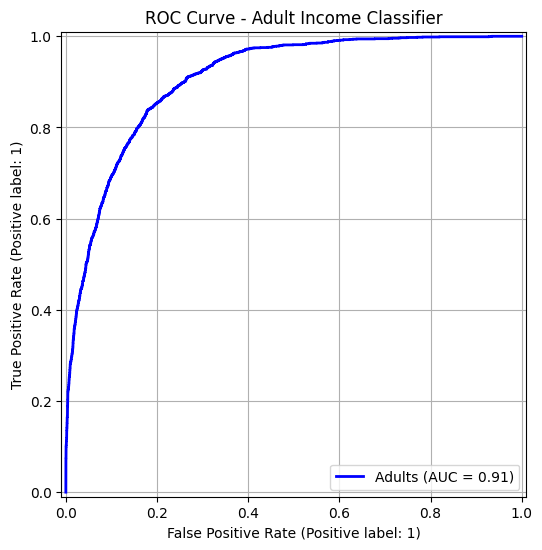

In [ ]:
# Generate an ROC curve for your model.
import matplotlib.pyplot as plt

prediction_proba = pipeline.predict_proba(X_test)[:, 1]
auc_score_final = roc_auc_score(y_test, prediction_proba)

fig, ax = plt.subplots(figsize=(6, 100))
RocCurveDisplay.from_predictions(
    y_test,
    prediction_proba,
    name=f"Adults",
    ax=ax,
    curve_kwargs={"color": "blue", "lw": 2},
)
"""
RocCurveDisplay.from_predictions(
    y_test,
    prediction_proba * 0.5,
    name="A second curve",
    ax=ax,
    curve_kwargs={"color": "orange", "lw": 2, "linestyle": "--"},
)
"""
ax.set_title("ROC Curve - Adult Income Classifier")
ax.grid(True)
plt.show()